In [1]:
!pip install llama-index==0.9.45.post1 arize-phoenix==2.2.1 pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5

In [2]:
from llama_index.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
)
from llama_index.query_engine.pandas import PandasInstructionParser
from llama_index.llms import OpenAI
from llama_index.prompts import PromptTemplate

In [3]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./diabetes_prediction_dataset.csv")
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0.0,1.0,never,25.19,6.6,140.0,0.0
1,Female,54.0,0.0,0.0,No Info,27.32,6.6,80.0,0.0
2,Male,28.0,0.0,0.0,never,27.32,5.7,158.0,0.0
3,Female,36.0,0.0,0.0,current,23.45,5.0,155.0,0.0
4,Male,76.0,1.0,1.0,current,20.14,4.8,155.0,0.0
...,...,...,...,...,...,...,...,...,...
55041,Male,70.0,0.0,0.0,former,26.88,5.8,140.0,1.0
55042,Male,13.0,0.0,0.0,never,20.54,4.0,140.0,0.0
55043,Male,52.0,0.0,0.0,never,29.05,6.1,140.0,0.0
55044,Male,47.0,0.0,0.0,No Info,27.32,4.5,160.0,0.0


In [7]:
from llama_index.query_engine.pandas import PandasInstructionParser

class CustomPandasInstructionParser(PandasInstructionParser):
    def __init__(self, df):
        # Initialize the original PandasInstructionParser
        super().__init__(df)

    def default_output_processor(self, code):

        # Clean the generated code by removing markdown formatting
        cleaned_code = code.replace('```python', '').replace('```', '').strip()

        # Log the cleaned code for debugging
        print("Cleaned code:", cleaned_code)

        # Try executing the cleaned code
        try:
            exec(cleaned_code)
            # Ensure the plot is shown if plt.show() wasn't included
        except Exception as e:
            print(f"Error executing the code: {e}")


In [26]:
instruction_str = (
    "1. Convert the query to executable Python code using Pandas and visualization libraries like seaborn or matplotlib if applicable.\n"
    "2. Ensure that necessary libraries such as pandas, seaborn and matplotlib are imported at the beginning of the code (e.g., 'import pandas as pd', `import seaborn as sns`, `import matplotlib.pyplot as plt`).\n"
    "3. The final line of code should be a Python expression that can be called with the 'eval()' function or 'plt.show()'.\n"
    "4. For visualizations, plot the result using seaborn or matplotlib and call 'plt.show()'.\n"
    "5. The code should represent a solution to the query without any unnecessary comments or triple-quoted strings.\n"
    "6. PRINT ONLY THE EXPRESSION OR THE VISUALIZATION.\n"
    "7. Do not quote the expression.\n"
    "8. GIVE ONLY EXECUTABLE PYTHON CODE without any unnecessary comments or triple-quoted strings.\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "The query may involve either a data operation or generating a visualization.\n"
    "Query: {query_str}\n\n"
    "Expression or Visualization Code:"
)

response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output (could be numerical or a visualization):\n{pandas_output}\n\n"
    "If the output is numerical, summarize the results.\n"
    "If the output is a visualization, explain what the visualization shows and provide key insights based on the plot.\n"
    "FOR VISUALIZATIONS GIVE RESPONSE THAT TALKS ABOUT THE VALUES IN THE GRAPH AND WHAT INSIGHTS WE CAN GET FROM THE GRAPH"
    "Response: "
)


pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df.head(5)
)
pandas_output_parser = CustomPandasInstructionParser(df)
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)
llm = OpenAI(model="gpt-3.5-turbo")

In [27]:

qp = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
    },
    verbose=True,
)
qp.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)
# add link from response synthesis prompt to llm2
qp.add_link("response_synthesis_prompt", "llm2")

In [28]:
from pyvis.network import Network
from IPython.core.display import display, HTML

# Create the network object
net = Network(notebook=True, cdn_resources="in_line", directed=True)

# Assuming you have a networkx graph 'qp.dag'
net.from_nx(qp.dag)

# Generate the HTML file (you can give any name here)
net.show("text2pandas_dag.html")

# Open the HTML file and read its contents
with open("text2pandas_dag.html", "r", encoding="utf-8") as f:
    html_data = f.read()

# Display the HTML content directly in the Jupyter notebook
display(HTML(html_data))


text2pandas_dag.html


## Query1

In [29]:
response = qp.run(
    query_str="What is the correlation value between bmi and age?",
)

> Running module input with input: 
query_str: What is the correlation value between bmi and age?

> Running module pandas_prompt with input: 
query_str: What is the correlation value between bmi and age?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import pandas as pd
import seaborn as sns

correlation = df['bmi'].corr(df['age'])
correlation

> Running module response_synthesis_prompt with input: 
query_str: What is the correlation value between bmi and age?
pandas_instructions: assistant: import pandas as pd
import seaborn as sns

correlation = df['bmi'].corr(df['age'])
correlation
pandas_output: 0.3336803125898642

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from th

In [30]:
print(response.message.content)

The correlation value between BMI and age is 0.334, indicating a positive correlation between the two variables. This means that as age increases, BMI tends to increase as well. This information can be useful in understanding the relationship between age and BMI in a given dataset.


## Query 2

> Running module input with input: 
query_str: Give a correlation matrix for HbA1c_level, blood_glucose_level, age, and bmi	?

> Running module pandas_prompt with input: 
query_str: Give a correlation matrix for HbA1c_level, blood_glucose_level, age, and bmi	?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['HbA1c_level', 'blood_glucose_level', 'age', 'bmi']].corr()
sns.heatmap(corr, annot=True, cmap='coolwar...



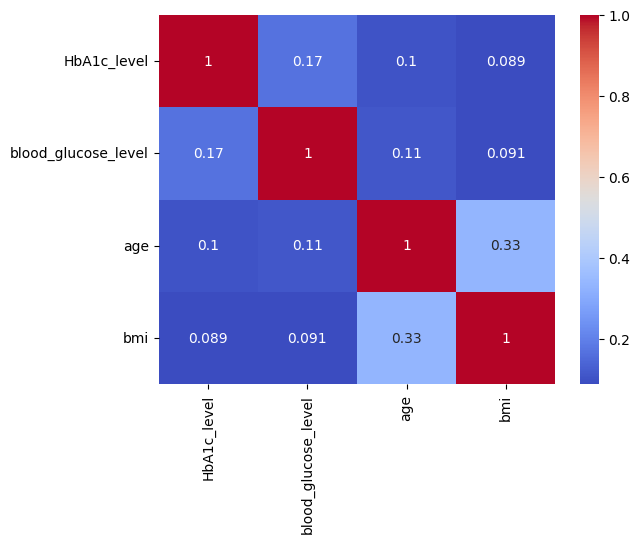

> Running module response_synthesis_prompt with input: 
query_str: Give a correlation matrix for HbA1c_level, blood_glucose_level, age, and bmi	?
pandas_instructions: assistant: import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['HbA1c_level', 'blood_glucose_level', 'age', 'bmi']].corr()
sns.heatmap(corr, annot=True, cmap='coolwar...
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: Give a correlation matrix for HbA1c_level, blood_glucose_level, age, and bmi	?

Pandas Instructions (optional):
import pan...



In [31]:
response = qp.run(
    query_str="Give a correlation matrix for HbA1c_level, blood_glucose_level, age, and bmi	?",
)

In [32]:
print(response.message.content)

The correlation matrix for HbA1c_level, blood_glucose_level, age, and bmi shows the strength and direction of the relationships between these variables. The values in the heatmap range from -1 to 1, with 1 indicating a perfect positive correlation, -1 indicating a perfect negative correlation, and 0 indicating no correlation.

From the visualization, we can see that there is a positive correlation between HbA1c_level and blood_glucose_level, which is expected as higher blood glucose levels are associated with higher HbA1c levels. There is also a positive correlation between age and blood_glucose_level, suggesting that blood glucose levels may increase with age. The correlation between age and bmi appears to be weaker, indicating a less strong relationship between these variables.

Overall, this correlation matrix provides valuable insights into the relationships between these key health indicators, which can be useful for understanding potential risk factors and informing healthcare de

## Query3

> Running module input with input: 
query_str: Give a bar plot using mathplotlib showing number of people with and without hypertension?

> Running module pandas_prompt with input: 
query_str: Give a bar plot using mathplotlib showing number of people with and without hypertension?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import matplotlib.pyplot as plt

df['hypertension'].value_counts().plot(kind='bar')
plt.xlabel('Hypertension')
plt.ylabel('Count')

plt.show()



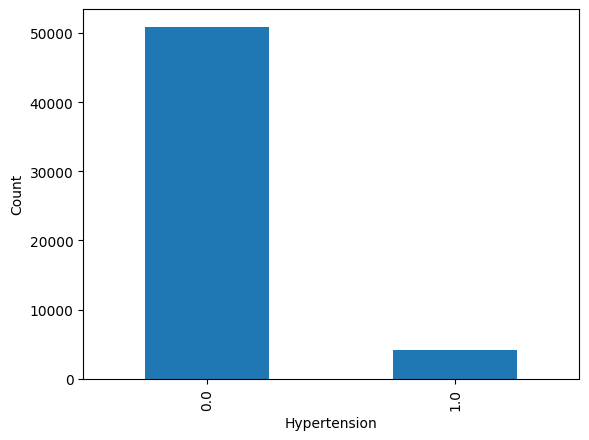

> Running module response_synthesis_prompt with input: 
query_str: Give a bar plot using mathplotlib showing number of people with and without hypertension?
pandas_instructions: assistant: import matplotlib.pyplot as plt

df['hypertension'].value_counts().plot(kind='bar')
plt.xlabel('Hypertension')
plt.ylabel('Count')

plt.show()
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: Give a bar plot using mathplotlib showing number of people with and without hypertension?

Pandas Instructions (optional):...



In [33]:
response = qp.run(
    query_str="Give a bar plot using mathplotlib showing number of people with and without hypertension?",
)

In [34]:
print(response.message.content)

The bar plot shows the number of people with and without hypertension. From the visualization, we can see that there are more people without hypertension compared to those with hypertension. This information can be useful for understanding the distribution of hypertension within the population being studied.


## Query4

> Running module input with input: 
query_str: Give a visualization for understanding how different genders suffer from hypertension?

> Running module pandas_prompt with input: 
query_str: Give a visualization for understanding how different genders suffer from hypertension?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='gender', hue='hypertension', data=df)
plt.show()



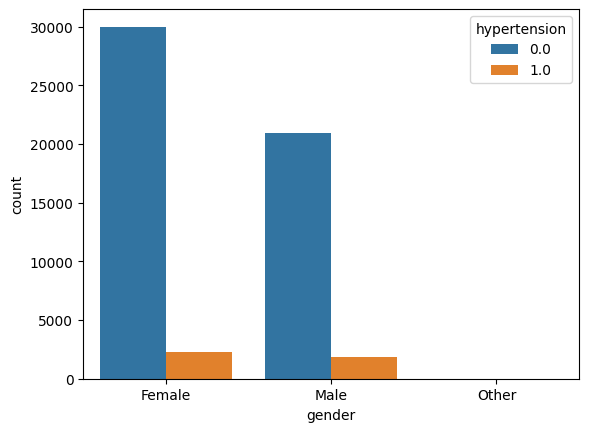

> Running module response_synthesis_prompt with input: 
query_str: Give a visualization for understanding how different genders suffer from hypertension?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='gender', hue='hypertension', data=df)
plt.show()
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: Give a visualization for understanding how different genders suffer from hypertension?

Pandas Instructions (optional):
im...



In [35]:
response = qp.run(
    query_str="Give a visualization for understanding how different genders suffer from hypertension?",
)

In [36]:
print(response.message.content)

The visualization provided is a countplot showing the distribution of hypertension among different genders. The x-axis represents the gender (male or female) and the hue represents whether or not they have hypertension.

From the plot, we can see that there is a higher prevalence of hypertension among males compared to females. This insight can be valuable for understanding the gender differences in the prevalence of hypertension and can help in developing targeted interventions for each gender. It also highlights the importance of considering gender-specific factors when addressing hypertension in healthcare settings.


## Query5

> Running module input with input: 
query_str: Give a visualization for understanding smokig history of the participants and also describe the output in graph?

> Running module pandas_prompt with input: 
query_str: Give a visualization for understanding smokig history of the participants and also describe the output in graph?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='smoking_history', data=df)
plt.xlabel('Smoking History')
plt.ylabel('Count')
plt.title('Smoking History of Participan...



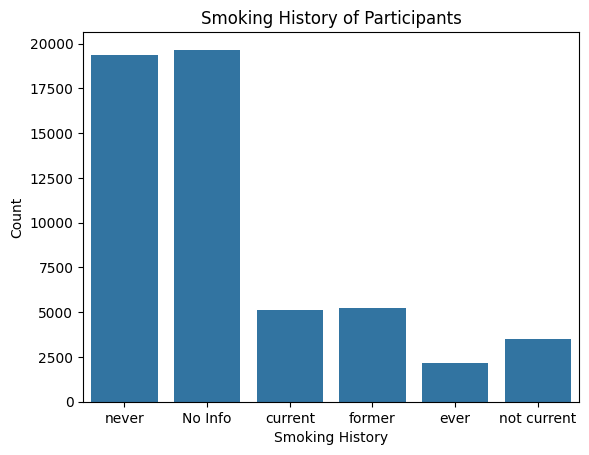

> Running module response_synthesis_prompt with input: 
query_str: Give a visualization for understanding smokig history of the participants and also describe the output in graph?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='smoking_history', data=df)
plt.xlabel('Smoking History')
plt.ylabel('Count')
plt.title('Smoking History of Participan...
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: Give a visualization for understanding smokig history of the participants and also describe the output in graph?

Pandas I...



In [37]:
response = qp.run(
    query_str="Give a visualization for understanding smokig history of the participants and also describe the output in graph?",
)

In [38]:
print(response.message.content)

The visualization provided is a countplot showing the smoking history of participants. The x-axis represents different categories of smoking history (e.g., never smoked, current smoker, former smoker), while the y-axis represents the count of participants in each category. 

From the graph, we can see the distribution of smoking history among the participants. This can provide insights into the prevalence of smoking within the sample population and help identify any trends or patterns related to smoking behavior. For example, we can see if there are more current smokers compared to former smokers, or if a significant portion of participants have never smoked. This information can be valuable for understanding the smoking habits of the study population and potentially informing public health interventions.


## Query6

> Running module input with input: 
query_str: I WANT TO UNDERSTND the relationship between age-groups and diabetes?

> Running module pandas_prompt with input: 
query_str: I WANT TO UNDERSTND the relationship between age-groups and diabetes?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='age', hue='diabetes', multiple='stack')
plt.show()



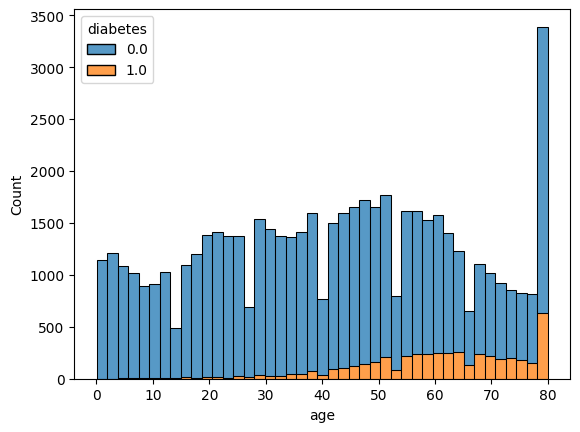

> Running module response_synthesis_prompt with input: 
query_str: I WANT TO UNDERSTND the relationship between age-groups and diabetes?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='age', hue='diabetes', multiple='stack')
plt.show()
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: I WANT TO UNDERSTND the relationship between age-groups and diabetes?

Pandas Instructions (optional):
import seaborn as s...



In [39]:
response = qp.run(
    query_str="I WANT TO UNDERSTND the relationship between age-groups and diabetes?",
)

In [40]:
print(response.message.content)

The visualization shows a stacked histogram of age groups and the presence of diabetes. Each bar represents a different age group, with the height of the bar indicating the number of individuals in that age group. The different colors within each bar represent the proportion of individuals with and without diabetes in that age group.

From the plot, we can see that the prevalence of diabetes tends to increase with age. Older age groups have a higher proportion of individuals with diabetes compared to younger age groups. This highlights the relationship between age and the likelihood of developing diabetes. This visualization can help in understanding how diabetes is distributed across different age groups and can be useful for identifying trends and patterns in the data.


## Query7

> Running module input with input: 
query_str: how can u best visualize the dependency of blood glucose level and if the person is suffering from diabetes?

> Running module pandas_prompt with input: 
query_str: how can u best visualize the dependency of blood glucose level and if the person is suffering from diabetes?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.show()



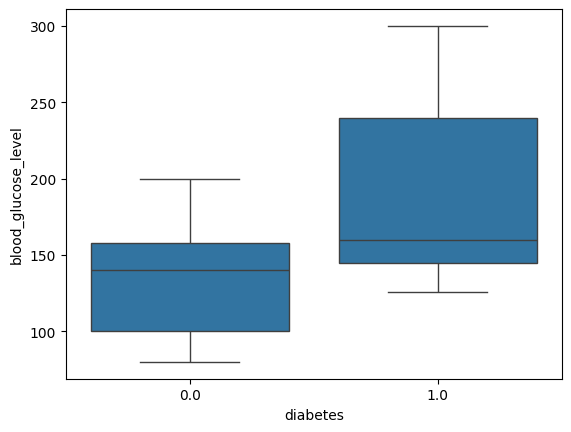

> Running module response_synthesis_prompt with input: 
query_str: how can u best visualize the dependency of blood glucose level and if the person is suffering from diabetes?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.show()
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: how can u best visualize the dependency of blood glucose level and if the person is suffering from diabetes?

Pandas Instr...



In [41]:
response = qp.run(
    query_str="how can u best visualize the dependency of blood glucose level and if the person is suffering from diabetes?",
)

In [42]:
print(response.message.content)

The visualization shows a boxplot of blood glucose levels for individuals with and without diabetes. The boxplot allows us to easily compare the distribution of blood glucose levels between the two groups. 

Key insights from the plot include:
- Individuals with diabetes tend to have higher blood glucose levels compared to those without diabetes.
- There is more variability in blood glucose levels among individuals with diabetes.
- The median blood glucose level is higher for individuals with diabetes.

Overall, this visualization effectively demonstrates the relationship between blood glucose levels and the presence of diabetes, highlighting the importance of monitoring blood glucose levels for individuals at risk of or already diagnosed with diabetes.


## Query8

> Running module input with input: 
query_str: give separate violine subplots for all the numeric value columns in the dataset?

> Running module pandas_prompt with input: 
query_str: give separate violine subplots for all the numeric value columns in the dataset?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for ...



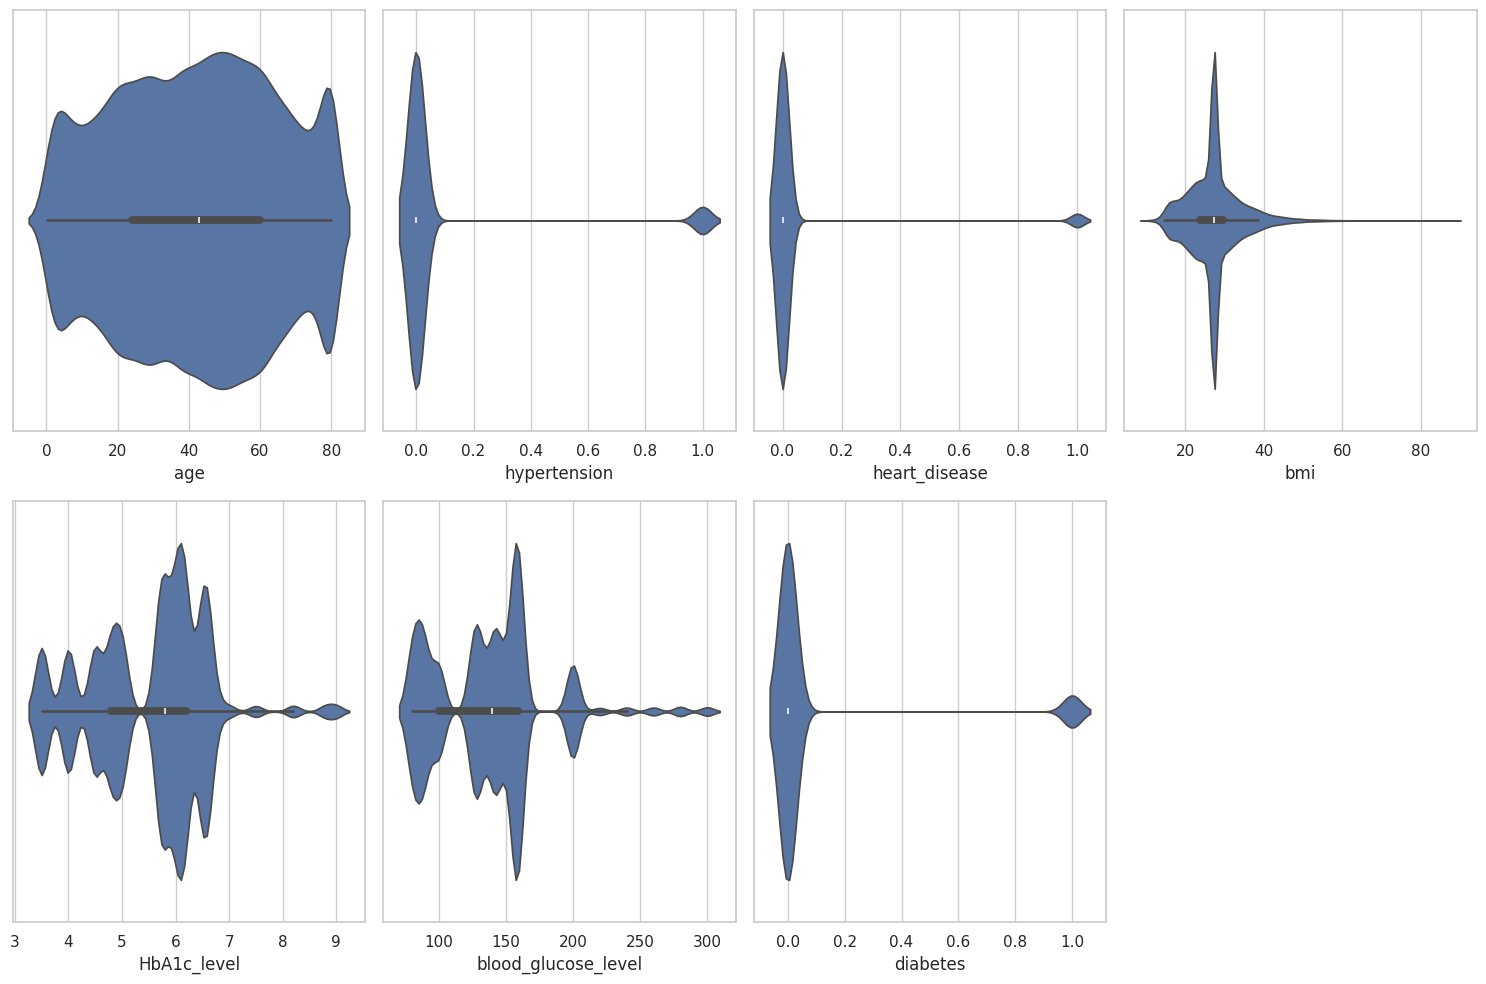

> Running module response_synthesis_prompt with input: 
query_str: give separate violine subplots for all the numeric value columns in the dataset?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for ...
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: give separate violine subplots for all the numeric value columns in the dataset?

Pandas Instructions (optional):
import s...



In [43]:
response = qp.run(
    query_str="give separate violine subplots for all the numeric value columns in the dataset?",
)

In [44]:
print(response.message.content)

The code provided will generate separate violin subplots for all the numeric value columns in the dataset. Each subplot will display the distribution of values for a specific numeric column using a violin plot. Violin plots are useful for visualizing the distribution of data and can provide insights into the spread and shape of the data.

By examining the violin plots generated for each numeric column, we can identify any outliers, the central tendency of the data, and the overall distribution shape. This can help us understand the variability and patterns present in the dataset's numeric values.


## Query9

> Running module input with input: 
query_str: give separate violine subplots for all the numeric value columns in the dataset. Numeric values dont include columns with 0 and 1 as input?

> Running module pandas_prompt with input: 
query_str: give separate violine subplots for all the numeric value columns in the dataset. Numeric values dont include columns with 0 and 1 as input?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['float64']).columns
numeric_columns = numeric_columns.drop(['hypertension', 'heart_disease...



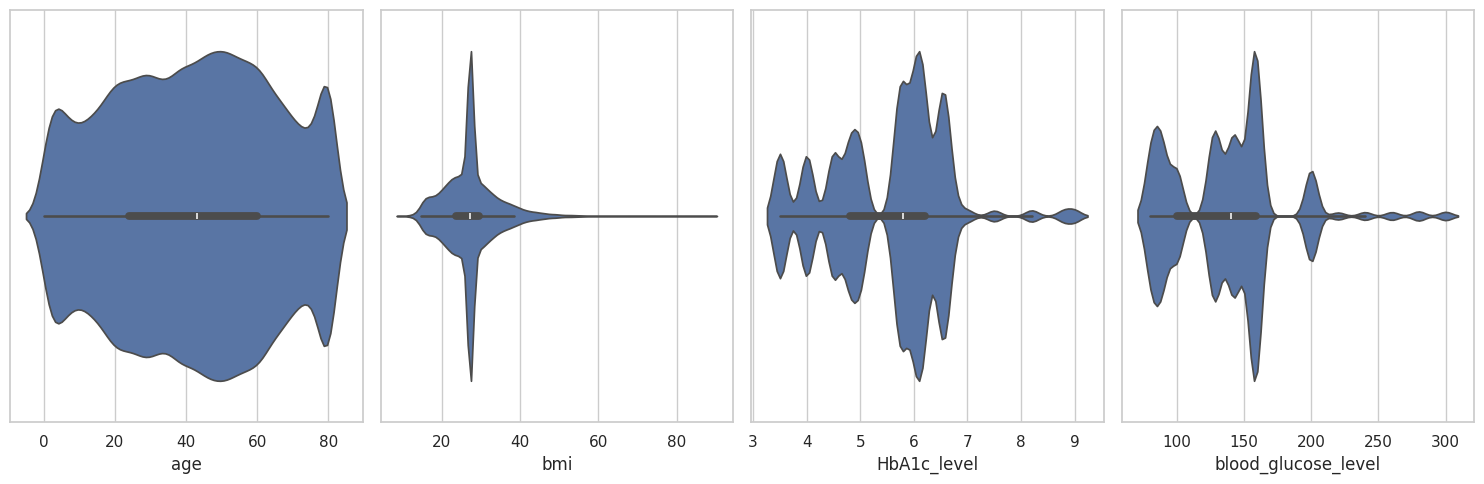

> Running module response_synthesis_prompt with input: 
query_str: give separate violine subplots for all the numeric value columns in the dataset. Numeric values dont include columns with 0 and 1 as input?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['float64']).columns
numeric_columns = numeric_columns.drop(['hypertension', 'heart_disease...
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: give separate violine subplots for all the numeric value columns in the dataset. Numeric values dont include columns with ...



In [45]:
response = qp.run(
    query_str="give separate violine subplots for all the numeric value columns in the dataset. Numeric values dont include columns with 0 and 1 as input?",
)

In [46]:
print(response.message.content)

The code provided will generate separate violin subplots for all the numeric value columns in the dataset, excluding columns with 0 and 1 as input. Each subplot will display the distribution of values for a specific numeric column using a violin plot. Violin plots show the distribution of the data, including the median, quartiles, and the overall shape of the distribution.

By examining these violin subplots, we can gain insights into the spread and central tendency of the numeric values in each column. This visualization can help identify any outliers, the presence of multiple peaks or modes, and the overall variability in the data. It provides a comprehensive view of the distribution of numeric values across different columns in the dataset.


## Query10

> Running module input with input: 
query_str: give separate boxplots subplots for all the numeric value columns in the dataset depending on wether the person suffers from diabetes. Numeric values dont include columns with 0 and 1 as input?

> Running module pandas_prompt with input: 
query_str: give separate boxplots subplots for all the numeric value columns in the dataset depending on wether the person suffers from diabetes. Numeric values dont include columns with 0 and 1 as input?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['float64']).columns
numeric_columns = numeric_columns.drop(['hypertension', 'heart_disease

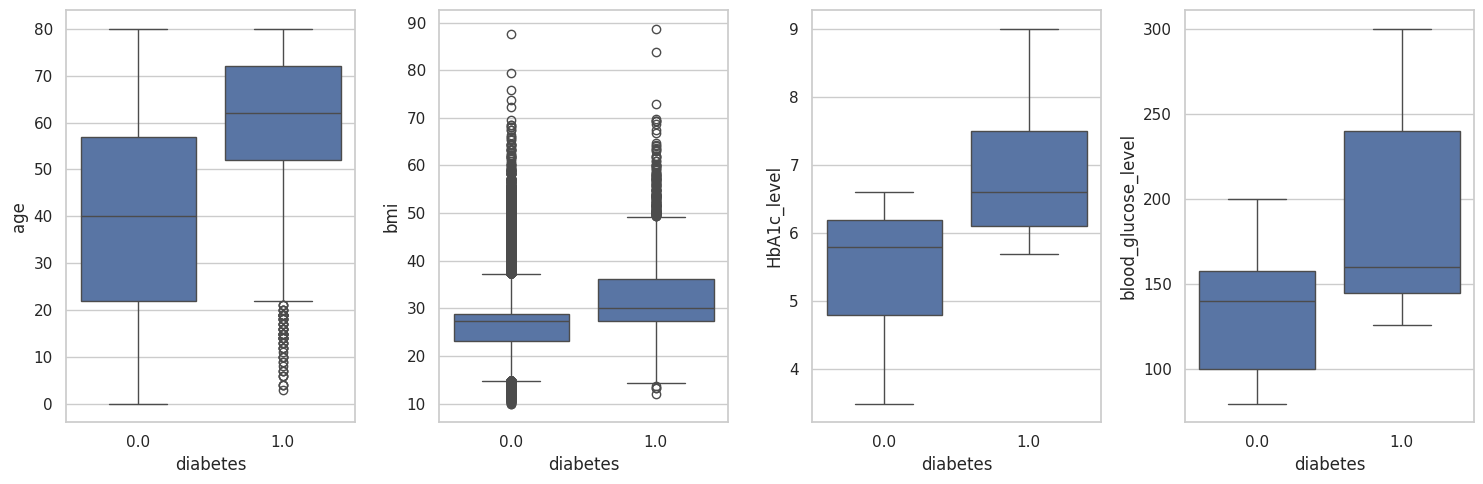

> Running module response_synthesis_prompt with input: 
query_str: give separate boxplots subplots for all the numeric value columns in the dataset depending on wether the person suffers from diabetes. Numeric values dont include columns with 0 and 1 as input?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['float64']).columns
numeric_columns = numeric_columns.drop(['hypertension', 'heart_disease...
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: give separate boxplots subplots for all the numeric value columns in the dataset depending on wether the person suffers fr...



In [47]:
response = qp.run(
    query_str="give separate boxplots subplots for all the numeric value columns in the dataset depending on wether the person suffers from diabetes. Numeric values dont include columns with 0 and 1 as input?",
)

In [48]:
print(response.message.content)

The visualization shows separate boxplots for all the numeric value columns in the dataset based on whether the person suffers from diabetes. Each subplot represents a different numeric column, excluding columns with 0 and 1 as input. 

From the boxplots, we can observe the distribution of each numeric variable among individuals with and without diabetes. This can help us identify any potential differences in the distribution of these variables between the two groups. By comparing the boxplots side by side, we can gain insights into how diabetes may impact these numeric values in the dataset.


## Query 11

> Running module input with input: 
query_str: How can u best visualize the relation between the columns smoking_history and heart disease, all three columns?

> Running module pandas_prompt with input: 
query_str: How can u best visualize the relation between the columns smoking_history and heart disease, all three columns?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0...

> Running module pandas_output_parser with input: 
input: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='smoking_history', hue='heart_disease', data=df)
plt.show()



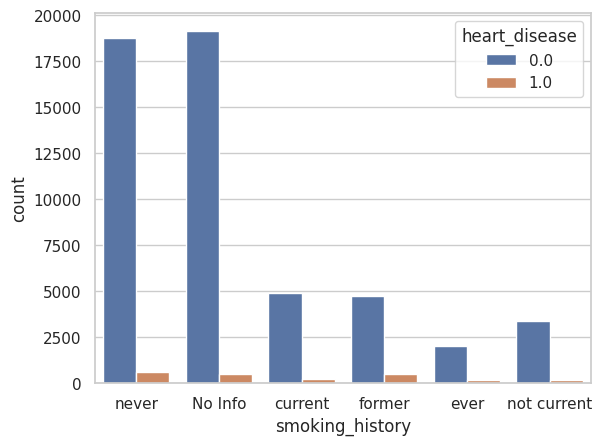

> Running module response_synthesis_prompt with input: 
query_str: How can u best visualize the relation between the columns smoking_history and heart disease, all three columns?
pandas_instructions: assistant: import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='smoking_history', hue='heart_disease', data=df)
plt.show()
pandas_output: None

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: How can u best visualize the relation between the columns smoking_history and heart disease, all three columns?

Pandas In...



In [49]:
response = qp.run(
    query_str="How can u best visualize the relation between the columns smoking_history and heart disease, all three columns?",
)

In [50]:
print(response.message.content)

The visualization shows a countplot of the relationship between smoking history and heart disease. The x-axis represents the different categories of smoking history (e.g. non-smoker, current smoker, former smoker) and the bars are colored based on the presence or absence of heart disease. 

From the plot, we can see the distribution of heart disease among different smoking history categories. This can help us understand if there is a correlation between smoking history and heart disease. For example, if there are more cases of heart disease among current smokers compared to non-smokers, it suggests a potential link between smoking and heart disease. 

Overall, this visualization provides a clear way to visualize and analyze the relationship between smoking history and heart disease in the dataset.
